# Predicting Horses health outcome 

## 0. Importing libraries

In [47]:
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from dash import Dash, dcc, html, Input, Output

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

import numpy as np
import math

import tensorflow as ts

import xgboost as xgb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import Dropout
from keras.optimizers import Adam

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import make_pipeline


import matplotlib.pyplot as plt



import tensorflow as tf 
ts.random.set_seed(42)

## 1. Loading the data 

In [48]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [49]:
test_df.columns

Index(['id', 'surgery', 'age', 'hospital_number', 'rectal_temp', 'pulse',
       'respiratory_rate', 'temp_of_extremities', 'peripheral_pulse',
       'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis',
       'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux',
       'nasogastric_reflux_ph', 'rectal_exam_feces', 'abdomen',
       'packed_cell_volume', 'total_protein', 'abdomo_appearance',
       'abdomo_protein', 'surgical_lesion', 'lesion_1', 'lesion_2', 'lesion_3',
       'cp_data'],
      dtype='object')

In [50]:
train_df.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


## 2. Descriptive analysis 

In [51]:
nbr_lin = len(train_df)
nbr_col = len(train_df.columns)
print('Number of rows: {}'.format(nbr_lin))
print('Number of columns: {}'.format(nbr_col))

Number of rows: 1235
Number of columns: 29


Wse dont have a huge amount of data, but this could be enough for the task

In [52]:
fig = px.pie(train_df, names='outcome', title='Distribution of the outcomes', width=400, height=400)
fig.show()

We can observe that the majority of the horses lived. We could first try to see how the outcome would be when setting euthanized and died to simply died. If this is gets a good precision, we could then predict each outcome. 

In [53]:
train_df['binary_outcome'] = train_df.outcome.map({'died': 'died', 'euthanized': 'died', 'lived': 'lived'})

In [54]:
fig = px.pie(train_df, names='binary_outcome', title='Distribution of the outcomes', width=400, height=400)
fig.show()

Looking at the binary outcome, we get a +/- balanced dataset.

We will now look at different features and how they behave by the outcomes.

In [55]:
x = 'abdomo_protein'
y = 'packed_cell_volume'
z = 'nasogastric_reflux_ph'

In [56]:
fig = px.scatter_3d(train_df, x = x, y= y , z= z , color='outcome', height= 500, width= 500)

fig.show()

In [57]:
fig = px.scatter_3d(train_df, x=x, y=y, z=z, color='binary_outcome', height= 500, width= 500)
fig.show()

We can see a very light discrimination. This is just the case for these features as the other do not show any evident dicrimination. This analysis is only for visual purposes and do not help by explaining the results. Nevertheless, it can give you a flavor of how to proceed for training. 

In [58]:
def plot_cats(df, targets, which, cols):
    cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()
    cat_cols = [x for x in cat_cols if x not in targets]
    col_names = [cat_cols[i:i+cols] for i in range(0, len(cat_cols), cols)]
    fig = make_subplots(rows=len(col_names), cols=cols, y_title='Count of occurences')
    colors = ['red', 'orange', 'green']  # Add more colors if needed

    for row in range(len(col_names)):
        for col in range(len(col_names[row])): 
            value_counts = df.groupby([col_names[row][col], targets[which]]).size().unstack(fill_value=0)
            for i, name in enumerate(value_counts.columns):
                if(row == 0 and col == 0):
                    fig.add_trace(go.Bar(x = value_counts.index,
                                y = value_counts[name],
                                legendgroup= name,
                                name=f'Target {name}',
                                marker_color=colors[i]
                                ),
                        row+1, col+1)
                else:
                    fig.add_trace(go.Bar(x = value_counts.index,
                                y = value_counts[name],
                                legendgroup= name,
                                showlegend=False,
                                name=f'Target {name}',
                                marker_color=colors[i],),
                        row+1, col+1)
                    
            fig.update_xaxes(title_text=col_names[row][col], row=row+1, col=col+1, tickangle=55)
    fig.update_layout(autosize=False,
                    barmode='stack',
                    width=550 * cols,
                    height=500 * len(col_names) )
    fig.show()

In [59]:
plot_cats(train_df, ["outcome", "binary_outcome"], 1, 8)

In [60]:
plot_cats(train_df, ["outcome", "binary_outcome"], 0, 8)

In this case, there aren't much values pointing out to one of the given targets. The only observable one is alert in the pain dimension, which shows that most alerted pain indexes resulted that the horse would live. 

In [61]:
app = Dash(__name__)

numer = train_df.select_dtypes(include=np.number).columns.tolist()
numer = [x for x in numer if x not in ['id', 'hospital_number']]

app.layout = html.Div([
    html.H4("Analysis of numerical values", style= {'backgroundColor':'white'}),
    html.P("x-axis:", style = {'backgroundColor':'white'}),
    dcc.Checklist(
        id='x-axis', 
        options= ['outcome', 'binary_outcome'],
        value=['outcome'], 
        inline=True,
        style = {'backgroundColor':'white'}
    ),
    html.P("y-axis:", style = {'backgroundColor':'white'}),
    dcc.RadioItems(
        id='y-axis', 
        options=numer,
        value='rectal_temp', 
        inline=True,
        style = {'backgroundColor':'white'}
    ),
    dcc.Graph(id="graph"),
])


@app.callback(
    Output("graph", "figure"), 
    Input("x-axis", "value"), 
    Input("y-axis", "value"))
def generate_chart(x, y):
    df = train_df
    fig = px.box(df, x=x, y=y, template='plotly_white')
    return fig


app.run_server(debug=True)

OSError: Address 'http://127.0.0.1:8050' already in use.
    Try passing a different port to run_server.

<AxesSubplot:>

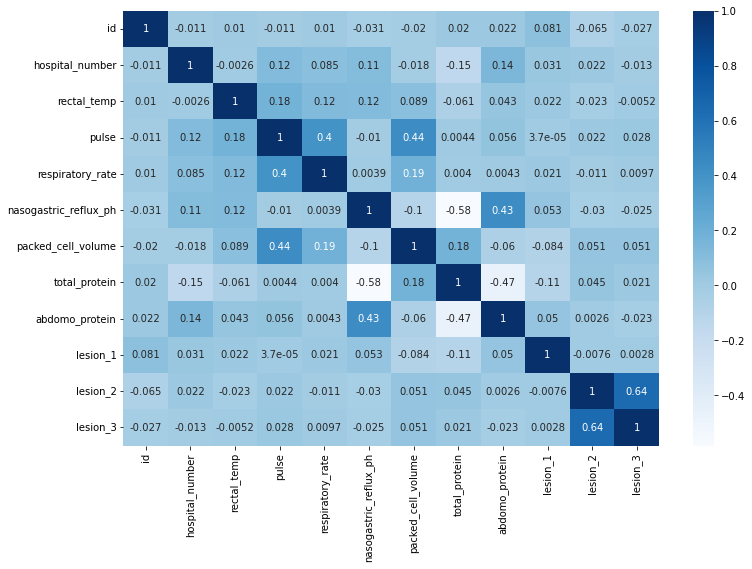

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(train_df.corr(), annot=True, cmap="Blues")

In general, we don't see any remarkable correlations between the numerical values. Making it hard to get a feeling of the dataset.

## 3. Predictive analysis or classification 

### 0. Data preparation

In [ ]:
missing_counts = train_df.isna().sum()
print("\nNumber of Missing Values in Each Column:")
print(missing_counts)


Number of Missing Values in Each Column:
id                       0
surgery                  0
age                      0
hospital_number          0
rectal_temp              0
pulse                    0
respiratory_rate         0
temp_of_extremities      0
peripheral_pulse         0
mucous_membrane          0
capillary_refill_time    0
pain                     0
peristalsis              0
abdominal_distention     0
nasogastric_tube         0
nasogastric_reflux       0
nasogastric_reflux_ph    0
rectal_exam_feces        0
abdomen                  0
packed_cell_volume       0
total_protein            0
abdomo_appearance        0
abdomo_protein           0
surgical_lesion          0
lesion_1                 0
lesion_2                 0
lesion_3                 0
cp_data                  0
outcome                  0
binary_outcome           0
dtype: int64


The data is already clean

We will first perform scaling 

<AxesSubplot:>

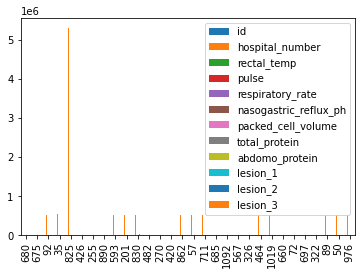

In [ ]:
train_df.sample(n = 30).plot(kind= 'bar')

The data is not scaled.

In [ ]:
train_df = train_df.drop('id', axis = 1)
train_df = train_df.drop('hospital_number', axis = 1)

In [ ]:

def scale_data(df):

    scaler = MinMaxScaler()

    numer = df.select_dtypes(include=np.number)
    numer = [x for x in numer if x not in ['id', 'hospital_number']]


    min_max_scaled = df.copy()

    min_max_scaled[numer] = scaler.fit_transform(min_max_scaled[numer])

    return min_max_scaled

<AxesSubplot:>

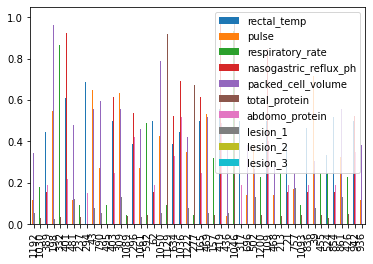

In [ ]:
train_min_max_scaled = scale_data(train_df)
test_min_max_scaled = scale_data(test_df)
train_min_max_scaled.sample(n = 50).plot(kind= 'bar')

Now that the data is scaled, we will divide the training and testing set into x and y.

In [ ]:
from sklearn.model_selection import train_test_split

y_multi = train_min_max_scaled.outcome.map({'died': 1, 'lived': 0, 'euthanized': 2 })
y_binary = train_min_max_scaled.binary_outcome.map({'died': 1, 'lived': 0})
X = train_min_max_scaled.drop('outcome', axis = 1)
X = X.drop('binary_outcome', axis = 1)

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X,y_multi , 
                                                                            random_state=104,  
                                                                            test_size=0.25,  
                                                                            shuffle=True)

X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(X,y_binary , 
                                                                            random_state=104,  
                                                                            test_size=0.25,  
                                                                            shuffle=True)

X_val = test_min_max_scaled

### 1. Without Optimisation

#### 1. SGD Classifier

##### SGD unoptimized

In [ ]:
from sklearn.linear_model import SGDClassifier



def train_pred_SGD(X_train, y_train, X_test, y_test, acc_score, alpha = 0.001, loss='log', n_jobs=-1, avg = None, penalty= 'l1'):

    model = SGDClassifier(loss=loss, n_jobs = n_jobs, alpha = alpha, penalty = penalty, random_state= 42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    conf = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(conf).plot()
    print("score: {}".format(acc_score(y_test, y_pred)))
    print("F1: {}".format(f1_score(y_test, y_pred, average=avg)))
    print("Precision: {}".format(precision_score(y_test, y_pred, average=avg)))
    print("Recall {}".format(recall_score(y_test, y_pred, average=avg)))


Binary

In [ ]:
numer = X_train_binary.select_dtypes(include=np.number)
numer = [x for x in numer if x not in ['id','hospital_number']]
train_pred_SGD(X_train_binary[numer], y_train_binary, X_test_binary[numer], y_test_binary, acc_score=roc_auc_score, avg = "binary", penalty= 'l1')

NameError: name 'metrics' is not defined

We reached a score of 66% in binary accuracy during training which is not all too bad for an unoptimized training case. We could improve the results. We would only need to optimize the false positive rate (precision) and the false negativ rate(recall).

First we will check how the multi classification scores.

score: 0.6116504854368932
F1: 0.6116504854368932
Precision: 0.6116504854368932
Recall 0.6116504854368932


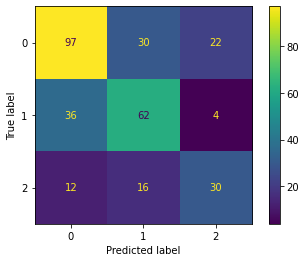

In [ ]:
numer = X_train_multi.select_dtypes(include=np.number)
numer = [x for x in numer if x not in ['id','hospital_number']]
train_pred_SGD(X_train_multi[numer], y_train_multi, X_test_multi[numer], y_test_multi, acc_score=accuracy_score, avg = 'micro')

As somehow expected, the results sligthly have fallen. 

##### 1.5 SGD optimized

###### Label encoding

We will first do a label encoding in order to add more data for higher granularity. As SGD classifier is a linear model, it would be better to do a count encoding. 

In [ ]:
def count_encoder(df, targets):
    df_enc = df.copy()
    cat_cols = df_enc.select_dtypes(exclude=np.number).columns.tolist()
    for target in targets:
        cat_cols.remove(target)
    for cat in cat_cols:
        count_map = df_enc[cat].value_counts().to_dict()
        df_enc[cat] = df_enc[cat].map(count_map)
    
    return df_enc

In [ ]:
df_enc = count_encoder(train_df, ['outcome', 'binary_outcome'])

train_min_max_scaled_enc = scale_data(df_enc)

y_multi_enc = train_min_max_scaled_enc.outcome.map({'died': 1, 'lived': 0, 'euthanized': 2 })
y_binary_enc = train_min_max_scaled_enc.binary_outcome.map({'died': 1, 'lived': 0})
X_enc = train_min_max_scaled_enc.drop('outcome', axis = 1)
X_enc = X_enc.drop('binary_outcome', axis = 1)

X_train_multi_enc, X_test_multi_enc, y_train_multi_enc, y_test_multi_enc = train_test_split(X_enc ,y_multi_enc , 
                                                                            random_state=104,  
                                                                            test_size=0.25,  
                                                                            shuffle=True)

X_train_binary_enc, X_test_binary_enc, y_train_binary_enc, y_test_binary_enc = train_test_split(X_enc ,y_binary_enc , 
                                                                            random_state=104,  
                                                                            test_size=0.25,  
                                                                            shuffle=True)

score: 0.7309354026845637
F1: 0.7414330218068534
Precision: 0.7391304347826086
Recall 0.74375


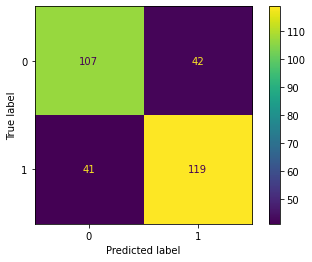

In [ ]:
train_pred_SGD(X_train_binary_enc, y_train_binary_enc, X_test_binary_enc, y_test_binary_enc, acc_score=roc_auc_score, avg = 'binary')

score: 0.6990291262135923
F1: 0.6990291262135923
Precision: 0.6990291262135923
Recall 0.6990291262135923


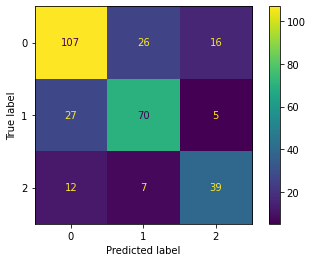

In [ ]:
train_pred_SGD(X_train_multi_enc, y_train_multi_enc, X_test_multi_enc, y_test_multi_enc, acc_score=accuracy_score, avg = 'micro')

###### Parfit (Parameter Grid)

In [ ]:
import parfit.parfit as pf
from sklearn.model_selection import ParameterGrid



def grid_parfit(X_train, y_train, X_test, y_test,  acc_score=accuracy_score):

    grid = {
        'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
        'loss': ['log'],
        'penalty': ['l1','l2'],
        'n_jobs': [-1],
        'random_state' : [42]
    }
    paramGrid = ParameterGrid(grid)

    bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier, paramGrid,
                                                            X_train, y_train, X_test, y_test, 
                                                            metric = acc_score,
                                                            scoreLabel = "accuracy")

    print(bestModel, bestScore)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:   24.8s remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:   25.2s remaining:   55.5s
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:   25.5s remaining:   32.8s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:   25.5s remaining:   19.8s
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:   25.5s remaining:   11.6s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:   25.7s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   25.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished


-------------SCORING MODELS-------------


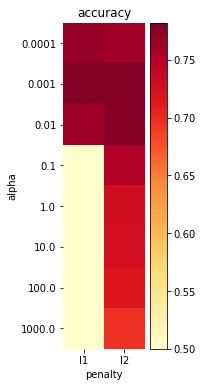

SGDClassifier(alpha=0.001, loss='log', n_jobs=-1, penalty='l1', random_state=42) 0.7822147651006711


In [ ]:
grid_parfit(X_train_binary_enc, y_train_binary_enc, X_test_binary_enc, y_test_binary_enc, acc_score = roc_auc_score)

score: 0.7309354026845637
F1: 0.7414330218068534
Precision: 0.7391304347826086
Recall 0.74375


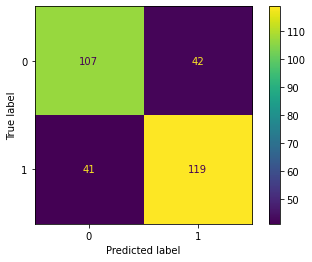

In [ ]:
train_pred_SGD(X_train_binary_enc, y_train_binary_enc, X_test_binary_enc, y_test_binary_enc, acc_score = roc_auc_score, alpha=0.001, loss='log', n_jobs=-1, penalty='l1', avg = 'binary')

-------------FITTING MODELS-------------


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0752s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished


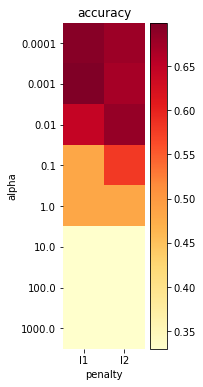

SGDClassifier(alpha=0.001, loss='log', n_jobs=-1, penalty='l1', random_state=42) 0.6990291262135923


In [ ]:
grid_parfit(X_train_multi_enc, y_train_multi_enc, X_test_multi_enc, y_test_multi_enc, acc_score = accuracy_score)

score: 0.6699029126213593
F1: 0.6564677942218559
Precision: 0.6633314746627955
Recall 0.6537762833282662


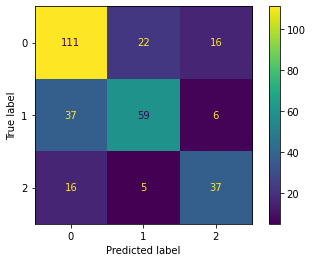

In [ ]:
train_pred_SGD(X_train_multi_enc, y_train_multi_enc, X_test_multi_enc, y_test_multi_enc, acc_score = accuracy_score,  alpha=0.001, loss='log', n_jobs=-1, avg= 'macro', penalty= 'l2')

We were able to get better results by only adding the categorical values, we added a count labeling. 

We observed that adding parameters didn't add more value to the scores. This can be due to having used them arlready as default in other examples. 

#### 2. Neural Network 

We will continue with a neural network architecture, for that we will use the one-hot encoder to encode categorical data

In [ ]:
import keras.utils as ku

train_min_max_scaled = scale_data(train_df)

y_multi = ku.to_categorical(train_min_max_scaled.outcome.map({'died': 1, 'lived': 0, 'euthanized': 2 }))
y_binary = train_min_max_scaled.binary_outcome.map({'died': 1, 'lived': 0})
X = train_min_max_scaled.drop('outcome', axis = 1)
X = X.drop('binary_outcome', axis = 1)

X_enc_one_hot = pd.get_dummies(X)

X_train_binary_one_hot, X_test_binary_one_hot, y_train_binary_one_hot, y_test_binary_one_hot = train_test_split(X_enc_one_hot ,y_binary , 
                                                                            random_state=104,  
                                                                            test_size=0.25,  
                                                                            shuffle=True)
X_train_multi_one_hot, X_test_multi_one_hot, y_train_multi_one_hot, y_test_multi_one_hot = train_test_split(X_enc_one_hot ,y_multi , 
                                                                            random_state=104,  
                                                                            test_size=0.25,  
                                                                            shuffle=True)

##### Building a sequential model 

In [ ]:
input_dim = len(X_train_binary_one_hot.columns)

In [ ]:
model = Sequential()

model.add(Dense(5, activation = 'relu', input_dim = input_dim, kernel_regularizer=regularizers.l2(0.001)))

model.add(Dropout(0.5))

model.add(Dense(10, activation = 'relu'))

model.add(Dense(1, activation = 'sigmoid' ))

model.compile(optimizer= 'adam', loss= 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
early = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train_binary_one_hot, y_train_binary_one_hot, verbose = 1, epochs = 100, batch_size = 12, callbacks= early, validation_data=(X_test_binary_one_hot, y_test_binary_one_hot))

Epoch 1/100
78/78 [==============================] - 2s 6ms/step - loss: 6504.6289 - accuracy: 0.4968 - val_loss: 383.5165 - val_accuracy: 0.5178
Epoch 2/100
78/78 [==============================] - 0s 3ms/step - loss: 616.1605 - accuracy: 0.4773 - val_loss: 0.7029 - val_accuracy: 0.4822
Epoch 3/100
78/78 [==============================] - 0s 3ms/step - loss: 0.7040 - accuracy: 0.4590 - val_loss: 0.7005 - val_accuracy: 0.4822
Epoch 4/100
78/78 [==============================] - 0s 4ms/step - loss: 0.9798 - accuracy: 0.4590 - val_loss: 0.6992 - val_accuracy: 0.4822
Epoch 5/100
78/78 [==============================] - 0s 3ms/step - loss: 0.6992 - accuracy: 0.4482 - val_loss: 0.6982 - val_accuracy: 0.5178
Epoch 6/100
78/78 [==============================] - 0s 3ms/step - loss: 3.4856 - accuracy: 0.5205 - val_loss: 0.6978 - val_accuracy: 0.5178
Epoch 7/100
78/78 [==============================] - 0s 3ms/step - loss: 0.6971 - accuracy: 0.5410 - val_loss: 0.6975 - val_accuracy: 0.5178
Epoch 

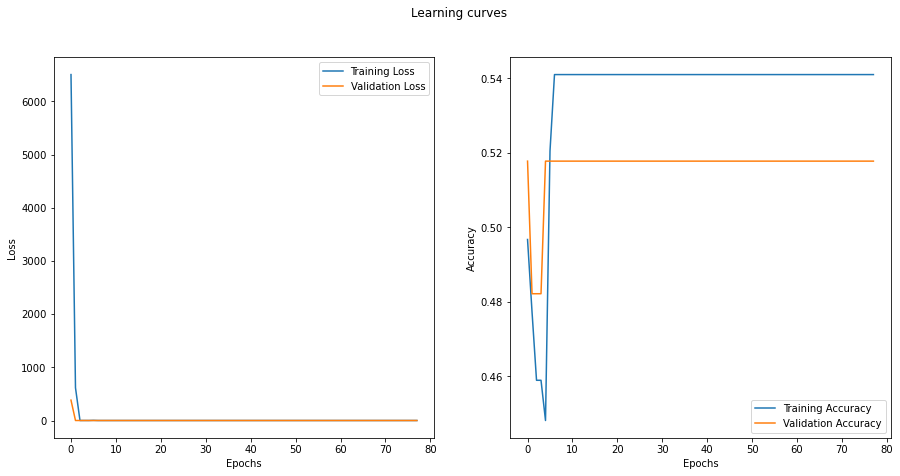

In [ ]:

loss_train = history.history['loss']
loss_val = history.history['val_loss']

accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']

fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].plot(history.epoch, loss_train, label='Training Loss')
ax[0].plot(history.epoch, loss_val, label='Validation Loss')

ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(history.epoch, accuracy_train, label='Training Accuracy')
ax[1].plot(history.epoch, accuracy_val, label='Validation Accuracy')

ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')

fig.suptitle('Learning curves')
fig.set_figheight(7)
fig.set_figwidth(15)
ax[0].legend()
ax[1].legend()


plt.show()

In [ ]:
y_pred = model.predict(X_test_binary_one_hot, batch_size = 12)
y_pred = pd.Series(y_pred.ravel())
tresh = 0.5
y_pred = np.where(y_pred >= tresh, 1, 0)
conf = metrics.confusion_matrix(y_test_binary_one_hot, y_pred)
metrics.ConfusionMatrixDisplay(conf).plot()
print("score: {}".format(accuracy_score(y_test_binary_one_hot, y_pred)))
print("F1: {}".format(f1_score(y_test_binary_one_hot, y_pred, average='binary')))
print("Precision: {}".format(precision_score(y_test_binary_one_hot, y_pred, average='binary')))
print("Recall {}".format(recall_score(y_test_binary_one_hot, y_pred, average='binary')))

26/26 [==============================] - 0s 2ms/step


NameError: name 'metrics' is not defined

We obtain results similar to those of the previous model. What is particularly intriguing is the trade-off between false positives (fp) and false negatives (fn). In this case, the model leans towards predicting a deadly outcome when making an error. Depending on the actions that professionals in the field decide to take, this model may be more advantageous to rely on. This can be adjusted with the treshhold. 

In [ ]:
input_dim = len(X_train_multi_one_hot.columns)

model = Sequential()

model.add(Dense(15, activation = 'relu', input_dim = input_dim, kernel_regularizer=regularizers.l2(0.001)))

model.add(Dense(3, activation = 'softmax' ))

model.compile(optimizer= 'adam', loss= 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
early = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train_multi_one_hot, y_train_multi_one_hot, verbose = 1, epochs = 100, batch_size = 12, callbacks= early, validation_data=(X_test_multi_one_hot, y_test_multi_one_hot))

Epoch 1/100
78/78 [==============================] - 1s 6ms/step - loss: 1.1127 - accuracy: 0.4460 - val_loss: 1.0063 - val_accuracy: 0.5243
Epoch 2/100
78/78 [==============================] - 0s 3ms/step - loss: 0.9352 - accuracy: 0.5562 - val_loss: 0.9180 - val_accuracy: 0.5955
Epoch 3/100
78/78 [==============================] - 0s 3ms/step - loss: 0.8734 - accuracy: 0.5853 - val_loss: 0.8681 - val_accuracy: 0.6181
Epoch 4/100
78/78 [==============================] - 0s 3ms/step - loss: 0.8213 - accuracy: 0.6371 - val_loss: 0.8332 - val_accuracy: 0.6278
Epoch 5/100
78/78 [==============================] - 0s 3ms/step - loss: 0.7802 - accuracy: 0.6814 - val_loss: 0.7951 - val_accuracy: 0.6537
Epoch 6/100
78/78 [==============================] - 0s 3ms/step - loss: 0.7453 - accuracy: 0.6976 - val_loss: 0.7804 - val_accuracy: 0.6537
Epoch 7/100
78/78 [==============================] - 0s 3ms/step - loss: 0.7266 - accuracy: 0.6987 - val_loss: 0.7626 - val_accuracy: 0.6505
Epoch 8/100
7

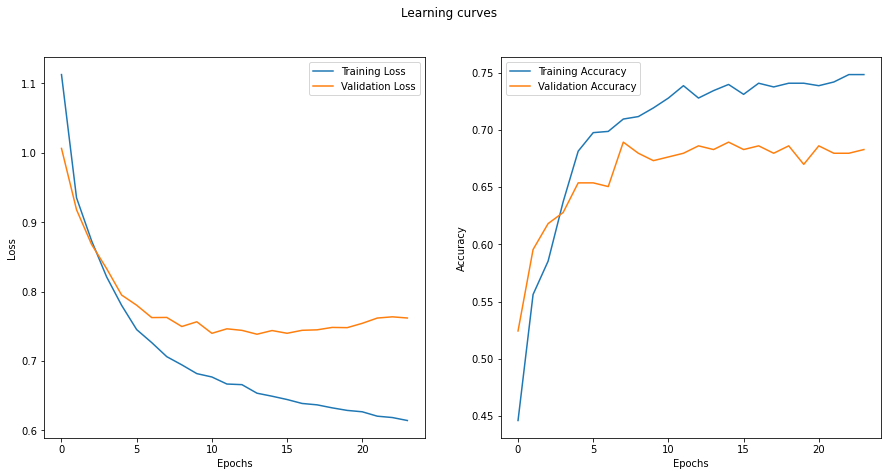

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']

accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']

fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].plot(history.epoch, loss_train, label='Training Loss')
ax[0].plot(history.epoch, loss_val, label='Validation Loss')

ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(history.epoch, accuracy_train, label='Training Accuracy')
ax[1].plot(history.epoch, accuracy_val, label='Validation Accuracy')

ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')

fig.suptitle('Learning curves')
fig.set_figheight(7)
fig.set_figwidth(15)
ax[0].legend()
ax[1].legend()


plt.show()

26/26 [==============================] - 0s 2ms/step
score: 0.6828478964401294
F1: 0.6648850435890117
Precision: 0.6718821150798711
Recall 0.6598281988101883


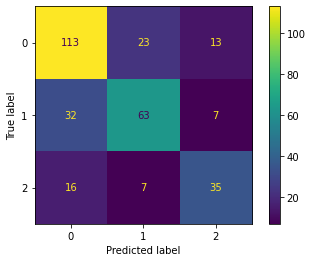

In [ ]:
y_pred = model.predict(X_test_multi_one_hot, batch_size = 12)
y_pred = np.argmax(y_pred, axis=1)
#y_pred = y_pred.tolist()
y_test_multi_one_hot_arg = np.argmax(y_test_multi_one_hot, axis=1)
conf = metrics.confusion_matrix(y_test_multi_one_hot_arg, y_pred)
metrics.ConfusionMatrixDisplay(conf).plot()
print("score: {}".format(accuracy_score(y_test_multi_one_hot_arg, y_pred)))
print("F1: {}".format(f1_score(y_test_multi_one_hot_arg, y_pred, average='macro')))
print("Precision: {}".format(precision_score(y_test_multi_one_hot_arg, y_pred, average='macro')))
print("Recall {}".format(recall_score(y_test_multi_one_hot_arg, y_pred, average='macro')))

On the multiclass classification, as expected, the results are sligthly below.

#### 2. Gradient boosting tree

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown= 'ignore')
train_min_max_scaled = scale_data(train_df)

cate = train_df.select_dtypes(exclude=np.number)
cate = [x for x in numer if x not in ['id', 'hospital_number']]

y_multi = train_min_max_scaled.outcome.map({'died': 1, 'lived': 0, 'euthanized': 2 })
y_binary = train_min_max_scaled.binary_outcome.map({'died': 1, 'lived': 0})
X = train_min_max_scaled.drop('outcome', axis = 1)
X = X.drop('binary_outcome', axis = 1)

X_enc_one_hot = pd.get_dummies(X)

X_train_binary_one_hot, X_test_binary_one_hot, y_train_binary_one_hot, y_test_binary_one_hot = train_test_split(X_enc_one_hot ,y_binary , 
                                                                            random_state=104,  
                                                                            test_size=0.25,  
                                                                            shuffle=True)
X_train_multi_one_hot, X_test_multi_one_hot, y_train_multi_one_hot, y_test_multi_one_hot = train_test_split(X_enc_one_hot ,y_multi , 
                                                                            random_state=104,  
                                                                            test_size=0.25,  
                                                                            shuffle=True)

In [ ]:
def train_pred_xgb(X_train, y_train, X_test, y_test, avg):

    model = xgb.XGBClassifier()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    conf = metrics.confusion_matrix(y_test, y_pred)
    metrics.ConfusionMatrixDisplay(conf).plot()
    print("score: {}".format(accuracy_score(y_test, y_pred)))
    print("F1: {}".format(f1_score(y_test, y_pred, average=avg)))
    print("Precision: {}".format(precision_score(y_test, y_pred, average=avg)))
    print("Recall {}".format(recall_score(y_test, y_pred, average=avg)))

score: 0.7993527508090615
F1: 0.819767441860465
Precision: 0.7663043478260869
Recall 0.88125


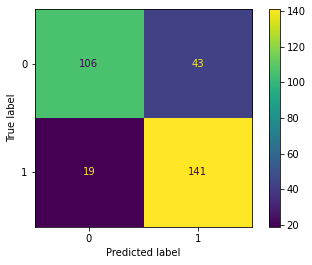

In [ ]:
train_pred_xgb(X_train_binary_one_hot, y_train_binary_one_hot, X_test_binary_one_hot, y_test_binary_one_hot, 'binary')

score: 0.7055016181229773
F1: 0.699891011774031
Precision: 0.695269732205023
Recall 0.7062431082129681


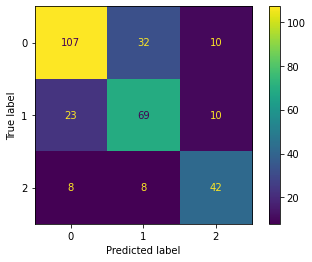

In [ ]:
train_pred_xgb(X_train_multi_one_hot, y_train_multi_one_hot, X_test_multi_one_hot, y_test_multi_one_hot, 'macro')

In [ ]:
from sklearn.model_selection import RandomizedSearchCV 

param_distributions = { 
    'learning_rate': [0.1, 0.01, 0.001, 0.0001], 
    'n_estimators': range(10, 301, 50 ) ,
    'max_depth' : range(2, 8, 1),
    'gamma': [0.1, 0.01, 0.001],
    'subsample': [0.8, 0.7, 0.85, 0.75],
    'reg_lambda': [1]
} 
model = xgb.XGBClassifier()
random_search_binary  = RandomizedSearchCV(model, param_distributions, cv=10, verbose= 1)
random_search_multi  = RandomizedSearchCV(model, param_distributions, cv=10, verbose= 1)

random_search_binary.fit(X_train_binary_one_hot, y_train_binary_one_hot)
random_search_multi.fit(X_train_multi_one_hot, y_train_multi_one_hot)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           min_child_weight=None, missing=nan,
                                           monotone_constra

In [ ]:
print('best binary: {} '.format(random_search_binary.best_params_))
print('best multi: {}'.format(random_search_multi.best_params_))

best binary: {'subsample': 0.8, 'reg_lambda': 1, 'n_estimators': 110, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.01} 
best multi: {'subsample': 0.7, 'reg_lambda': 1, 'n_estimators': 160, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.1}


In [ ]:
def train_pred_xgb_optim(X_train, y_train, X_test, y_test, avg, subsample, reg_lambda, n_estimators, max_depth, learning_rate, gamma):

    model = xgb.XGBClassifier(subsample = subsample, reg_lambda = reg_lambda, n_estimators = n_estimators, max_depth = max_depth, learning_rate = learning_rate, gamma = gamma)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    conf = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(conf).plot()
    print("score: {}".format(accuracy_score(y_test, y_pred)))
    print("F1: {}".format(f1_score(y_test, y_pred, average=avg)))
    print("Precision: {}".format(precision_score(y_test, y_pred, average=avg)))
    print("Recall {}".format(recall_score(y_test, y_pred, average=avg)))
    return model

score: 0.8058252427184466
F1: 0.8224852071005918
Precision: 0.7808988764044944
Recall 0.86875


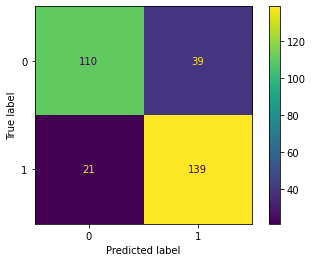

In [ ]:
xbg_binary = train_pred_xgb_optim(X_train_binary_one_hot, y_train_binary_one_hot, X_test_binary_one_hot, y_test_binary_one_hot, avg = 'binary', subsample = 0.8, reg_lambda = 1, n_estimators = 110, max_depth = 4, learning_rate = 0.1, gamma = 0.01)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

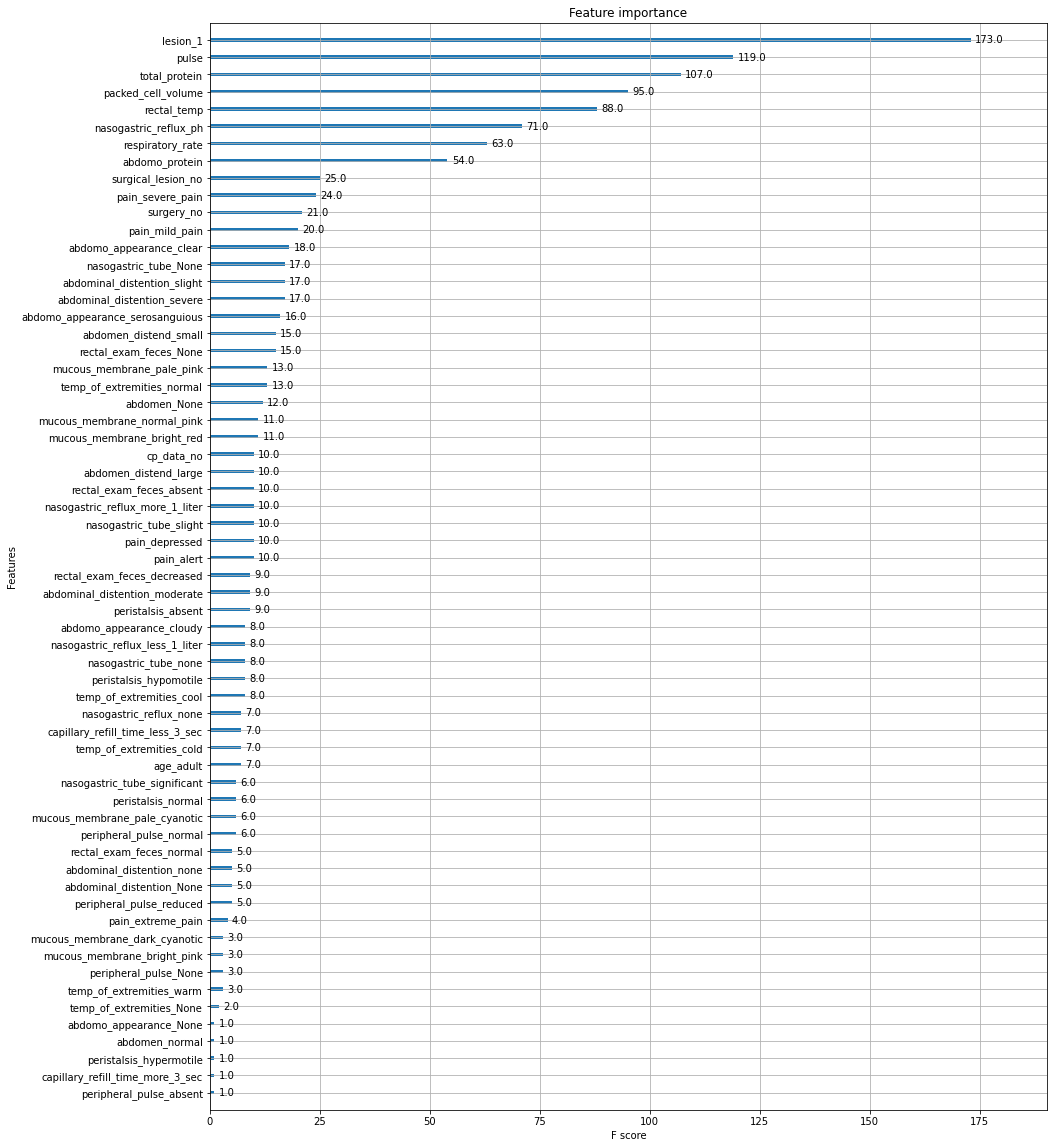

In [ ]:
fig, ax = plt.subplots(figsize=(15, 20))

xgb.plot_importance(xbg_binary, ax = ax)

In [ ]:
xgb_multi = train_pred_xgb_optim(X_train_multi_one_hot, y_train_multi_one_hot, X_test_multi_one_hot, y_test_multi_one_hot, avg = 'macro', subsample = 0.7, reg_lambda = 1, n_estimators = 160, max_depth = 2, learning_rate = 0.1, gamma = 0.1)

NameError: name 'train_pred_xgb_optim' is not defined

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

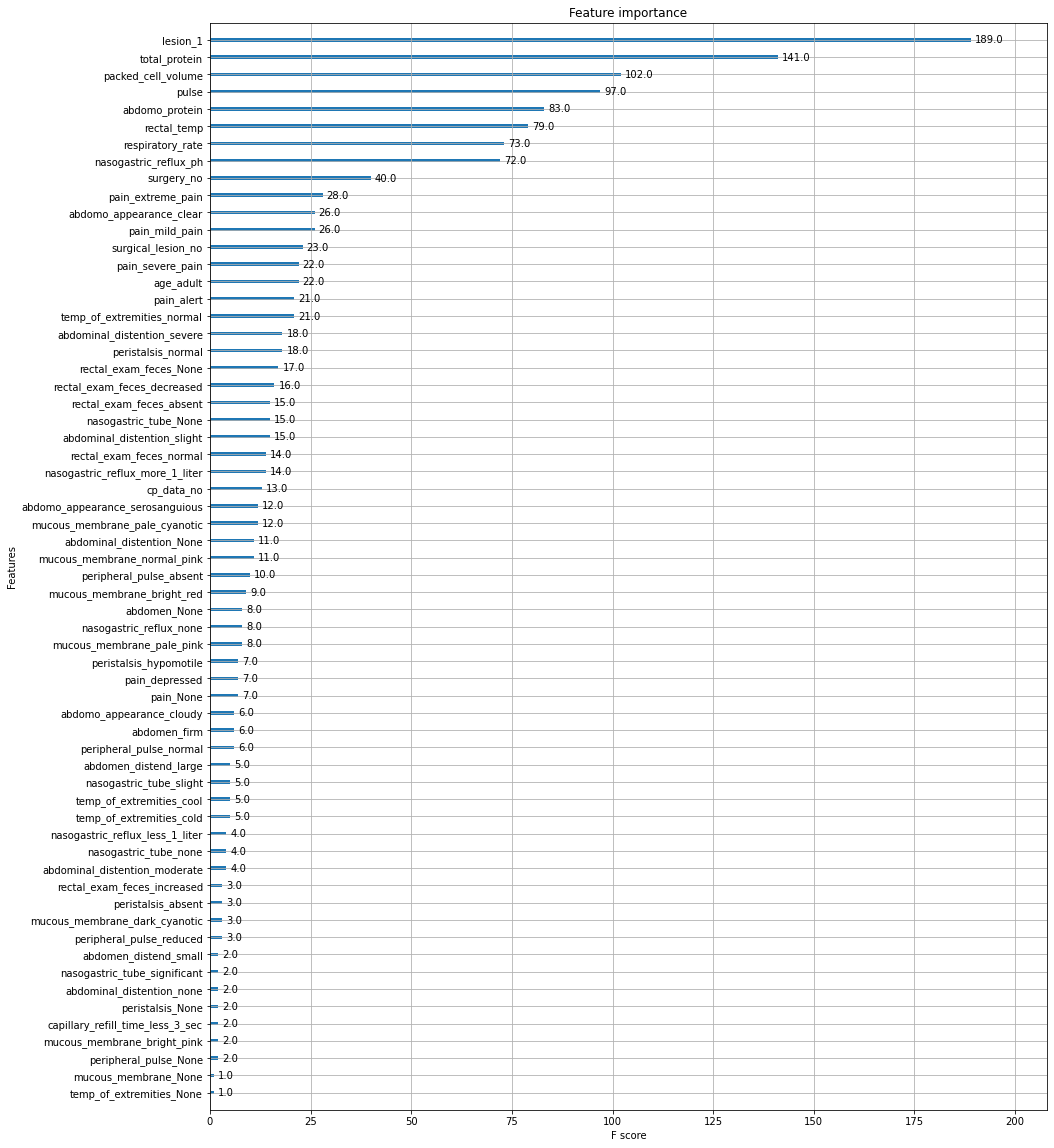

In [ ]:
fig, ax = plt.subplots(figsize=(15, 20))

xgb.plot_importance(xgb_multi, ax = ax)

XGBoost presented the best results in predicting the outcome of the horses health. In addition, XGboost tells us that lesion1, pulse and total_protein where the most important feature to detect the horses outcome. 

#### Pipeline for final model: XGBoost

In this section, we will create a data pipeling to automatically process for maintenance.

In [ ]:
def custom_pipeline_xgb_train_evaluate(df, case : str):

    temp = df.drop('id', axis = 1, errors= 'ignore')
    temp = df.drop('hospital_number', axis = 1, errors= 'ignore')

    y_multi = temp.outcome.map({'died': 1, 'lived': 0, 'euthanized': 2 })
    y_binary = temp.binary_outcome.map({'died': 1, 'lived': 0})
    temp = temp.drop('outcome', axis = 1)
    temp = temp.drop('binary_outcome', axis = 1)

    # scaling train and test on X side
    scaler = MinMaxScaler()
    
    numerical = temp.select_dtypes(include=np.number).columns
    
    temp_scaled = temp.copy()
    temp_scaled[numerical] = scaler.fit_transform(temp_scaled[numerical])
    temp_scaled_enc = pd.get_dummies(temp_scaled)

    X = temp_scaled_enc

    #initializing model and splits
    model = None
    avg = ''
    X_train, X_test, y_train, y_test = None, None, None, None
    if(case == 'binary'):
        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                            y_binary, 
                                                            random_state=42,  
                                                            test_size=0.25,  
                                                            shuffle=True)
        model = xgb.XGBClassifier(subsample = 0.8, reg_lambda = 1, n_estimators = 110, max_depth = 4, learning_rate = 0.1, gamma = 0.01, verbose = 0)
        avg = 'binary'
    elif (case == 'multi'):
        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                            y_multi, 
                                                            random_state=42,  
                                                            test_size=0.25,  
                                                            shuffle=True)
        model = xgb.XGBClassifier(subsample = 0.7, reg_lambda = 1, n_estimators = 160, max_depth = 2, learning_rate = 0.1, gamma = 0.1, verbose = 0)
        avg = 'macro'
    else: 
        raise ValueError('Parameter case should be binary or multi ')

    #training
    model.fit(X_train, y_train)

    #evaluation
    y_pred = model.predict(X_test)

    conf = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(conf).plot()

    print("score: {}".format(accuracy_score(y_test, y_pred)))
    print("F1: {}".format(f1_score(y_test, y_pred, average=avg)))
    print("Precision: {}".format(precision_score(y_test, y_pred, average=avg)))
    print("Recall {}".format(recall_score(y_test, y_pred, average=avg)))

    #feature importance
    fig, ax = plt.subplots(figsize=(15, 20))
    xgb.plot_importance(xgb_multi, ax = ax)

    return model    

score: 0.7443365695792881
F1: 0.7333279581769249
Precision: 0.751510583389166
Recall 0.7253170979198376


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=160, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

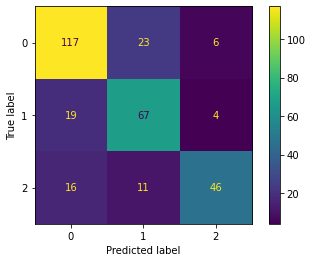

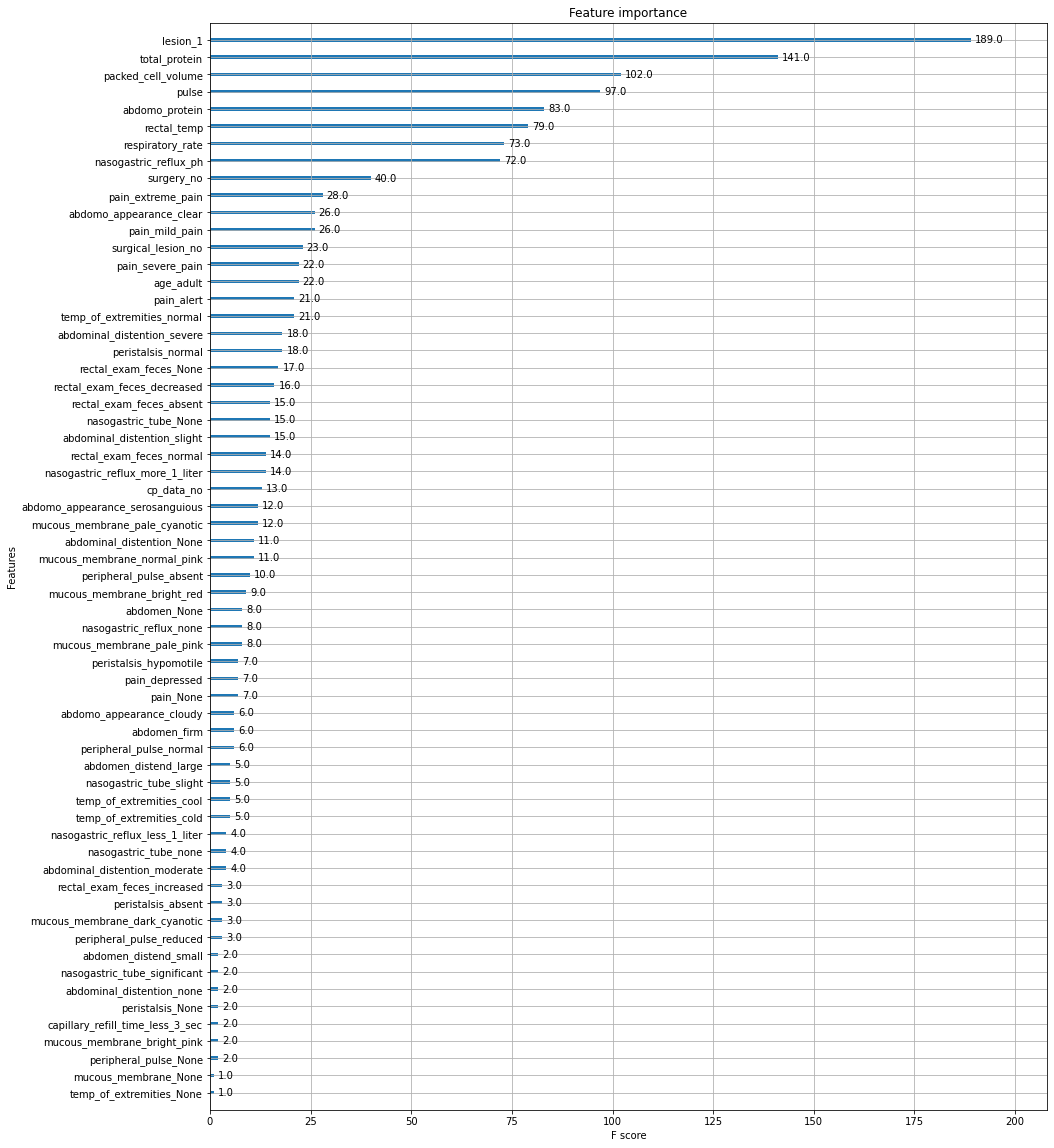

In [ ]:
custom_pipeline_xgb_train_evaluate(train_df, 'multi')